## Using Python Operators for Band Math in openEO

### Introduction

In geospatial analysis with openEO, we've previously explored how to connect data loading and saving directly, as well as how to introduce built-in processes like NDVI for analysis in between. Now, we’ll take it a step further by using Python's native operators to perform band math, such as subtraction, on satellite data.

While it may appear that these operations are happening directly within your local Python environment, it’s important to understand that the openEO Python client intelligently translates these operations into equivalent backend processes. For instance, a simple Python subtraction operation `A - B` on data cubes will actually be translated into the openEO `subtract(a, b)` process, which is then executed on the backend.

In this notebook, we will demonstrate how to use Python operators for band math through an example where we calculate the Normalized Difference Vegetation Index (NDVI). NDVI is a widely used metric for assessing vegetation health by comparing the difference between near-infrared (NIR) and red light reflected by vegetation. Specifically, we’ll show how to use the Python subtraction operator `-` and division operator `/` to perform the NDVI calculation, and we’ll highlight how these operations are translated into openEO processes by the Python client.

We’ll also emphasize the distinction between what is executed in the client (your notebook) and what is handled by the openEO backend, ensuring a clear understanding of the workflow.

### Objective

The objective of this tutorial is to show you how to use Python operators to perform band math on satellite data in openEO, using NDVI calculation as an example. We aim to help you understand the distinction between operations executed in the client and those processed by the backend. We will guide you through building a process tree that incorporates Python operators, and we will explore how these operations are reflected in the backend.

### In this notebook, you will explore the following concepts:

- **Translation of Python Operations to openEO Processes**: Learn how the openEO Python client converts Python operations, such as subtraction and division, into corresponding openEO backend processes.

- **Data Cube Loading**: Understand how to load satellite data into a data cube, which forms the basis for performing band math and other operations.

- **Band Extraction**: Explore how to select and work with individual spectral bands from a data cube and integrate these selections into a process tree.

- **Band Math Using Python Operators**: Delve into how Python operators like `-` (subtraction) and `/` (division) are used for band math and how these operations are seamlessly translated into openEO process trees.

- **Process Tree Optimization**: Compare different methods of constructing process trees, with and without intermediate variables, to understand their impact on computational efficiency.

- **Result Visualization**: Execute the final process tree and visualize the results using custom helper functions to ensure the calculations have been correctly performed.

### Tools You'll Use:

- **openEO**: To interact with satellite data, perform band math, and manage process trees.
- **Matplotlib via demo_helpers**: Custom helper functions for visualizing the results. The details of these functions can be found in `demo_helpers.py` if you wish to explore further.

### Learning Outcomes:

By the end of this tutorial, you will be able to:

- Understand how Python operators are translated into openEO processes by the openEO Python client and how these are executed on the backend.
- Extract individual bands from a data cube and understand how these operations are integrated into a process tree.
- Use Python operators to perform band math on satellite data, such as calculating NDVI using subtraction and division.
- Compare and analyze process trees generated with and without intermediate variables, and understand the impact on efficiency and optimization.
- Visualize and verify the results of these operations, such as an NDVI calculation, using custom helper functions (`demo_helpers.py`).
- Comprehend the distinction between operations executed in the client (your notebook) and those processed by the backend, ensuring a clear understanding of where and how computations occur.

This approach will enable you to efficiently perform and visualize band math on large datasets, leveraging the robust processing capabilities of the openEO backend while writing intuitive and familiar Python code in your notebook.

### Let's Begin

Firstly, let us import a few useful Python libraries and, as usual, connect to the backend.


In [1]:
import openeo
import config
from demo_regions import s2
from demo_helpers import show_result
conn = openeo.connect(config.eo_service_url)
conn.authenticate_basic(username=config.user, password=config.passwd)

<Connection to 'https://openeo.digitalearth.se/' with BasicBearerAuth>

## A. Exploring Available Processes
Use the result below to find details on the add and subtract processes. 


In [ ]:
conn.list_processes()

## B. Load Some Sample data
We will revisit the same area and timespan as we used when calculating the NDVI using the processes. We load the bands into a datacube and extract the different bands into two variables `red` and `nir` to increase readability. 

In [3]:
# B. Load Some Sample Data 
s2_datacube=conn.load_collection(collection_id=s2.s2_msi_l2a,
                         spatial_extent=s2.bbox.karlstad_mini_land,
                         temporal_extent=s2.timespans.one_image,
                         bands=['b08','b04'],
                                )
# Verify that we have a process graph with just one node, load_collection
s2_datacube.flat_graph()

{'loadcollection1': {'process_id': 'load_collection',
  'arguments': {'bands': ['b08', 'b04'],
   'id': 's2_msi_l2a',
   'spatial_extent': {'west': 13.460930954751282,
    'east': 13.585449709728213,
    'south': 59.36327761288911,
    'north': 59.40107161575003},
   'temporal_extent': ['2021-11-12T00:00:00Z', '2021-11-13T00:00:00Z']},
  'result': True}}

## C. Selecting Individual Bands
Next we Pick out the red band from the datacube. Note in the graph below how we add  processes to the process graph. Also note the two ways of showing the resulting graph (Interactive Graphics, and plain JSON).


In [4]:
red = s2_datacube.band('b04')
display(red) # a graphical way to view the process graph. 

In [5]:
# Then we pick out the nir band from the data cube
nir = s2_datacube.band('b08')
display(nir.flat_graph()) # Shows the same as above but as a JSON representation.

{'loadcollection1': {'process_id': 'load_collection',
  'arguments': {'bands': ['b08', 'b04'],
   'id': 's2_msi_l2a',
   'spatial_extent': {'west': 13.460930954751282,
    'east': 13.585449709728213,
    'south': 59.36327761288911,
    'north': 59.40107161575003},
   'temporal_extent': ['2021-11-12T00:00:00Z', '2021-11-13T00:00:00Z']}},
 'reducedimension1': {'process_id': 'reduce_dimension',
  'arguments': {'data': {'from_node': 'loadcollection1'},
   'dimension': 'bands',
   'reducer': {'process_graph': {'arrayelement1': {'process_id': 'array_element',
      'arguments': {'data': {'from_parameter': 'data'}, 'index': 0},
      'result': True}}}},
  'result': True}}

### Understanding How the openEO Python Client Creates a Process Tree

When you execute a line of code like `nir = s2_datacube.band('b08')`, the openEO Python client is doing much more than just selecting a band from your data cube. Behind the scenes, it is creating a process tree, which will be executed by the backend. Let's break down exactly what happens.
The Process Tree is:

1. **Loading the Collection**:
The process tree starts with the `load_collection? process, which loads the specified satellite data into a data cube. This process is where you define the collection ID, spatial extent, temporal extent, and the bands to be loaded (e.g., `['b08', 'b04']`).

2. **Reducing Dimensions**:
The next step is the reduce_dimension process. This process is used to reduce the dimensions of the data cube. Specifically, it allows you to operate on one dimension of the cube (e.g., bands) while keeping other dimensions intact.

In the case of `nir = s2_datacube.band('b08')`, the reduce_dimension process is applied to the bands dimension. The argument `bands` indicates that we want to reduce along the bands dimension, and the reducer function `array_element` is applied to select a specific element (or band) from the array, which is done in next step(3).

3. **Selecting the Band**:
The `array_element` process is used within `reduce_dimension` to pick the band corresponding to b08. The `index: 0` argument tells the process to select the first element in the band array (since b08 is the first band in the list `['b08', 'b04']` that was loaded with load_collection).

## D. Using Python Operators for Band Math 
Now we have two process trees, one for `red` and one for `nir`. Lets use them for making a quite more complex process, calculating the NDVI using the python operators `-`,`+`, and `/`. Can you find the processes in the interactive list from `list_processes` above ?   

In [6]:
# Perform band math to calculate NDVI using the defined variables (that corresponds to the process trees above)
ndvi = (nir - red) / (nir + red)
display(ndvi.flat_graph())
display(ndvi)

{'loadcollection1': {'process_id': 'load_collection',
  'arguments': {'bands': ['b08', 'b04'],
   'id': 's2_msi_l2a',
   'spatial_extent': {'west': 13.460930954751282,
    'east': 13.585449709728213,
    'south': 59.36327761288911,
    'north': 59.40107161575003},
   'temporal_extent': ['2021-11-12T00:00:00Z', '2021-11-13T00:00:00Z']}},
 'reducedimension1': {'process_id': 'reduce_dimension',
  'arguments': {'data': {'from_node': 'loadcollection1'},
   'dimension': 'bands',
   'reducer': {'process_graph': {'arrayelement1': {'process_id': 'array_element',
      'arguments': {'data': {'from_parameter': 'data'}, 'index': 0}},
     'arrayelement2': {'process_id': 'array_element',
      'arguments': {'data': {'from_parameter': 'data'}, 'index': 1}},
     'subtract1': {'process_id': 'subtract',
      'arguments': {'x': {'from_node': 'arrayelement1'},
       'y': {'from_node': 'arrayelement2'}}},
     'add1': {'process_id': 'add',
      'arguments': {'x': {'from_node': 'arrayelement1'},
      

Double click on the "reducer: Process" in the graph above to expand next level of details. Can you recognize the process nodes ? As an interesting comparison, let´s create the ndvi calculation without using the intermediate variables:

## D. Comparing Process Trees - with and without intermediate variables
In our example above, we created some intermediate variables for each band (`red`and `nir`). In the next cell we will take a look on how the resulting process tree would look like if we go the long way around and use the `s2_datacube.band('b08')` directly in the calculation and compare the resulting tree. Do not worry, we will explain what is happening further down in the notebook. 

In [7]:
# This is the same ndvi calculation as before, but without creating the intermediate process trees
long_ndvi = (s2_datacube.band('b08') - s2_datacube.band('b04')) / (s2_datacube.band('b08') + s2_datacube.band('b04'))
display(long_ndvi.flat_graph())
display(long_ndvi)

{'loadcollection1': {'process_id': 'load_collection',
  'arguments': {'bands': ['b08', 'b04'],
   'id': 's2_msi_l2a',
   'spatial_extent': {'west': 13.460930954751282,
    'east': 13.585449709728213,
    'south': 59.36327761288911,
    'north': 59.40107161575003},
   'temporal_extent': ['2021-11-12T00:00:00Z', '2021-11-13T00:00:00Z']}},
 'reducedimension1': {'process_id': 'reduce_dimension',
  'arguments': {'data': {'from_node': 'loadcollection1'},
   'dimension': 'bands',
   'reducer': {'process_graph': {'arrayelement1': {'process_id': 'array_element',
      'arguments': {'data': {'from_parameter': 'data'}, 'index': 0}},
     'arrayelement2': {'process_id': 'array_element',
      'arguments': {'data': {'from_parameter': 'data'}, 'index': 1}},
     'subtract1': {'process_id': 'subtract',
      'arguments': {'x': {'from_node': 'arrayelement1'},
       'y': {'from_node': 'arrayelement2'}}},
     'arrayelement3': {'process_id': 'array_element',
      'arguments': {'data': {'from_parameter

### Why Do the Process Graphs Differ?

You've just compared the two process graphs—one using intermediate variables (`nir` and `red`) and one using direct calculations—and noticed that they aren't identical. Let's clarify why this happens.

1. **Using Intermediate Variables (`nir` and `red`)**:
   - When you define `nir` and `red` as intermediate variables, the openEO Python client optimizes the process graph. It recognizes that both `nir` and `red` are derived from the same `reduce_dimension` operation. As a result, the client reuses the results of these operations within the process graph.
   - This means that in the process graph, the `reduce_dimension` operation (which extracts the NIR and Red bands) is performed once for each band. The subsequent operations—like subtraction and addition—use these pre-extracted bands. This optimization results in a more compact and efficient process graph.

2. **Direct Calculation Without Intermediate Variables**:
   - When you write out the NDVI calculation directly, without using intermediate variables, the openEO Python client doesn’t automatically recognize that the same band extraction operation is being repeated. Instead, it creates separate process nodes for each occurrence of `s2_datacube.band('b08')` and `s2_datacube.band('b04')`.
   - This results in a longer process graph, where the `reduce_dimension` and `array_element` operations are called twice for each band—once for the subtraction and once for the addition.

### The Key Differences

- **Reused Operations**:
  - **With Intermediate Variables**: The process graph is optimized, with the NIR and Red bands being extracted once and reused for both subtraction and addition.
  - **Without Intermediate Variables**: The process graph includes redundant operations because the NIR and Red bands are extracted multiple times, leading to more nodes in the graph.

- **Process Graph Length**:
  - **With Intermediate Variables**: The graph is more compact and efficient, with fewer repeated operations.
  - **Without Intermediate Variables**: The graph is longer and includes duplicated operations, making it slightly less efficient.

### Why This Matters

Understanding this difference is important because it shows you how the structure of your Python code can impact the efficiency of the process graph that is executed on the backend. By using intermediate variables, you help the openEO Python client optimize the graph, which can be especially beneficial in more complex analyses.

In summary, using intermediate variables leads to a more optimized and efficient process graph, while direct calculations without them can result in redundant operations. Both approaches yield the same NDVI result, but the process behind the scenes differs in terms of efficiency. This is one reason to keep an eye on the produced process tree.  


## F. Executing and Visualizing the Result
Now we execute the process tree and take a look at the result. Compare to the result when we used the built in NDVI process. Is it the same ? I hope so...


[<open DatasetReader name='/vsipythonfilelike/77e628cf-173f-4963-9b08-60319a322b84/77e628cf-173f-4963-9b08-60319a322b84' mode='r'>]

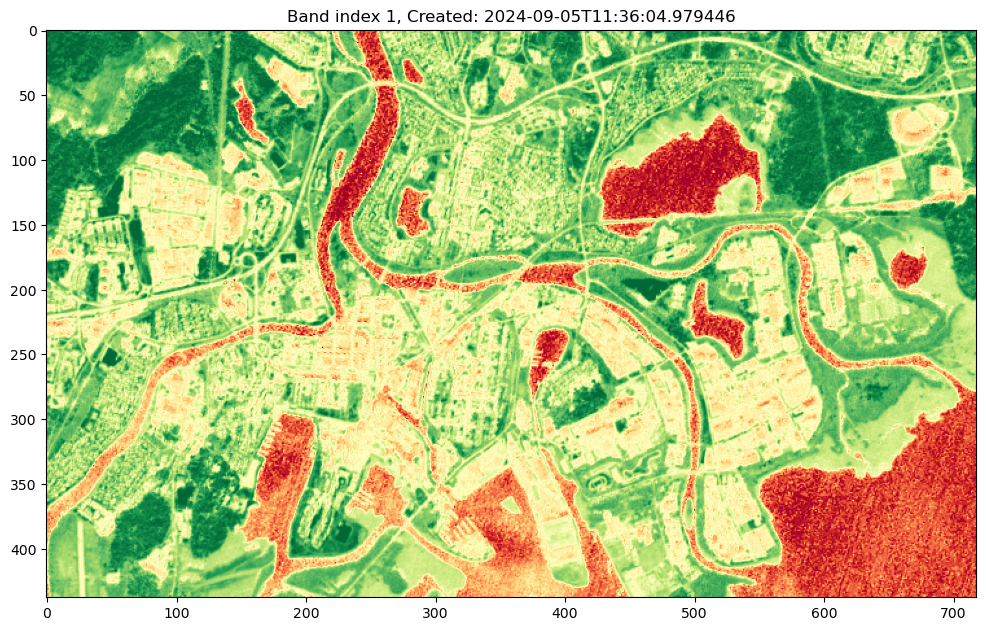

In [8]:
# Download the NDVI resul
ndvi_image_data = ndvi.download(format="gtiff")
show_result(ndvi_image_data,is_ndvi=True)